# Dat 402 Project 2
## Justin Raney and Anthony Colapinto 

## Project Goal
The goal of this project is to use KMeans Clustering, a Gated Recurrent Unit (GRU) model, and Logistic Regression to preform sentiment analysis on online reviews on different medications. Since reviews use words rather than just rating effectiness, this could identify trends such as if certain side-effects are precieved as worse, or other reasons why an effective medication might be rated poorly.

## Dataset
Drug Reviews (Druglib.com)

Source: https://archive.ics.uci.edu/dataset/461/drug+review+dataset+druglib+com

Instances: 4143

Features: 8

In [3]:
#import libraries 
import pandas as pd
import re
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

The latest version of each package as of May 3 2025 should work, but you may need to install tensorflow 2.18.0 instead of the latest 2.19 if you want to re-run the GruModel. 

# Data Cleaning

In [4]:
train_path = "drugLibTrain_raw.tsv"
test_path = "drugLibTest_raw.tsv"

train_df = pd.read_csv(train_path, sep="\t")
test_df = pd.read_csv(test_path, sep="\t")

# Convert to csv

train_df.to_csv("train_raw.csv", index=False)
test_df.to_csv("test_raw.csv", index=False)

# I plan to rejoin this split, so the source column allows for tracing back to the original dataset split
train_df["source"] = "train"
test_df["source"] = "test"

combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df.to_csv("full_drug_reviews.csv", index=False)

In [5]:
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("Combined Shape:", combined_df.shape)
print("Columns:", combined_df.columns.tolist())

Train Shape: (3107, 10)
Test Shape: (1036, 10)
Combined Shape: (4143, 10)
Columns: ['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview', 'source']


In [6]:
print("\nSample:")
print(combined_df.sample(5))


Sample:
      Unnamed: 0  urlDrugName  rating           effectiveness  \
2203        4049       amoxil       8  Considerably Effective   
1748        2610  adderall-xr       9  Considerably Effective   
2245        3617      retin-a       7  Considerably Effective   
2634        3080  minocycline       9  Considerably Effective   
990         1229     ultracet      10        Highly Effective   

                sideEffects                       condition  \
2203        No Side Effects  infected site of oreal surgery   
1748      Mild Side Effects                            adhd   
2245  Moderate Side Effects                      sun damage   
2634      Mild Side Effects                            acne   
990         No Side Effects                    fibromyalgia   

                                         benefitsReview  \
2203  The infection that developed at the site of my...   
1748  Patient was able to regain appropriate focus, ...   
2245  sun damage (freckles on forehead) have

In [7]:
# Unnamed: 0 is seen from the printout, let's remove that
combined_df = combined_df.drop(columns=["Unnamed: 0"])
print("Missing Values:")
print(combined_df.isna().sum())

Missing Values:
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       23
sideEffectsReview    98
commentsReview       13
source                0
dtype: int64


In [8]:
# The number of missing values is less than 150, I'll check to see if there are any rows missing multiple fields.
print(combined_df[["benefitsReview", "sideEffectsReview", "commentsReview"]].isna().sum(axis=1).value_counts())

0    4014
1     125
2       3
3       1
Name: count, dtype: int64


In [9]:
# Fill the na text columns with "No Content"
text_cols = ["benefitsReview", "sideEffectsReview", "commentsReview"]
combined_df[text_cols] = combined_df[text_cols].fillna("No Content")
print(combined_df.isna().sum())

urlDrugName          0
rating               0
effectiveness        0
sideEffects          0
condition            1
benefitsReview       0
sideEffectsReview    0
commentsReview       0
source               0
dtype: int64


In [10]:
# The last remaining na is a condition, let's see if we can find out what the condition is.
drug_name = combined_df[combined_df["condition"].isna()]["urlDrugName"].values[0]
matched = combined_df[combined_df["urlDrugName"] == drug_name]
print(matched["condition"].unique())

['pre-surgery' 'shortness of breath, itching all over'
 'severe upper respitory tract infection' 'tooth infection'
 'polinoidal cyst' 'bladder infections' 'skin wound/infection' nan
 'post surgery antibiotic' 'post operative antibiotic'
 'infected lymph node' 'chronic sinusitis'
 'tonsillitis, sinusitis also bad tooth ache.' 'kidney infection']


In [11]:
# These results show infections and pre-surgery use. This is indicative of antibiotics, but we can"t be sure as there are many conditions.
# Let's check the reviews for any information.

print(combined_df[combined_df["condition"].isna()].index)
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    print(combined_df[combined_df["condition"].isna()])

Index([2488], dtype='int64')
     urlDrugName  rating effectiveness      sideEffects condition  \
2488      keflex       2   Ineffective  No Side Effects       NaN   

                                                                                           benefitsReview  \
2488  None.  I had a bacterial infection accompanying my flu and there wasnt a single noticeable benefit.   

                                                                                                                                                               sideEffectsReview  \
2488  The only good point I suppose is that there was no adverse reaction, such as yeast infection or stomach upset. The downside was the bacterial infection quickly got worse.   

                                                                                                                                                                                          commentsReview  \
2488  Absoutely innefective.  I easily could hav

In [12]:
# "The downside was the bacterial infection quickly got worse." <- This is the condition, so we will fill the NA condition field with bacterial infection.
na_index = combined_df[combined_df["condition"].isna()].index[0]
combined_df.loc[na_index, "condition"] = "bacterial infection"
# Finally, we will combine the review fields and rename the columns for ease of use.
combined_df["review"] = (combined_df["benefitsReview"].astype(str) + " " + combined_df["sideEffectsReview"].astype(str) + " " +
    combined_df["commentsReview"].astype(str))

# Drop original columns and rename for ease of use.
combined_df.drop(columns=text_cols, inplace=True)

combined_df.rename(columns={
    "urlDrugName": "drug",
    "sideEffects": "side_effects"}, inplace=True)

print(combined_df.sample(5))
combined_df.to_csv("cleaned_data.csv", index=False)
# Everything looks good, I will now start EDA

                  drug  rating           effectiveness           side_effects  \
1557          nuvaring       7  Considerably Effective      Mild Side Effects   
3080  risperdal-consta       9  Considerably Effective        No Side Effects   
2253           latisse      10  Considerably Effective        No Side Effects   
1423        wellbutrin       6  Considerably Effective  Moderate Side Effects   
2845             xanax       5  Considerably Effective  Moderate Side Effects   

                                              condition source  \
1557                             acne and birth control  train   
3080                                 psychotic symptoms  train   
2253                                       eyelash loss  train   
1423                                         depression  train   
2845  to help me sleep after having a rapid heartbea...  train   

                                                 review  
1557  I switched from Diane 35, a birth control pill...  


# Exploratory Analysis

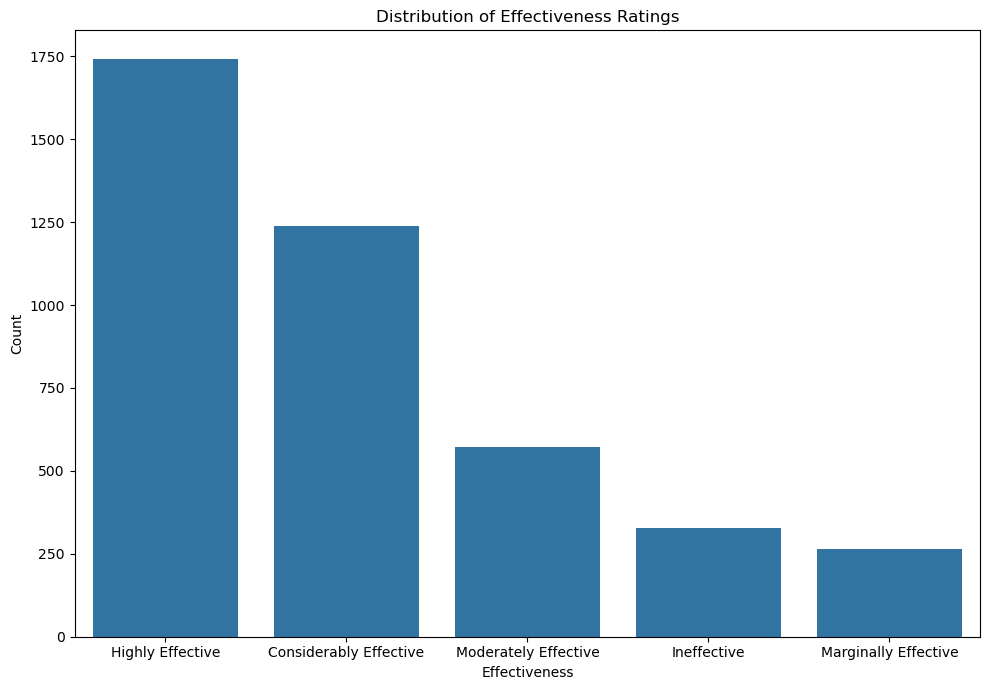

In [14]:
cleaned_df = pd.read_csv("cleaned_data.csv", sep=",")

# Check the distribution of effectiveness
# This plot shows a significant gap between highly effective and marginally effective, this could cause issues if not accounted for when training models
plt.figure(figsize=(10, 7))
sns.countplot(data=cleaned_df, x="effectiveness", order=cleaned_df["effectiveness"].value_counts().index)
plt.title("Distribution of Effectiveness Ratings")
plt.xlabel("Effectiveness")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

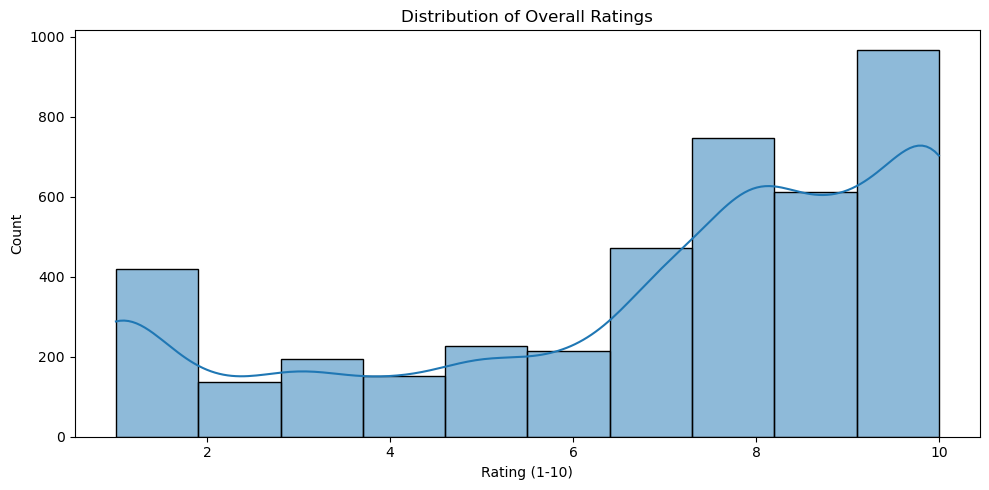

In [15]:
# Check Rating distribution
# As the above suggests, this could cause bias introduction, may need to be normalized.
plt.figure(figsize=(10, 5))
sns.histplot(data=cleaned_df, x="rating", bins=10, kde=True)
plt.title("Distribution of Overall Ratings")
plt.xlabel("Rating (1-10)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

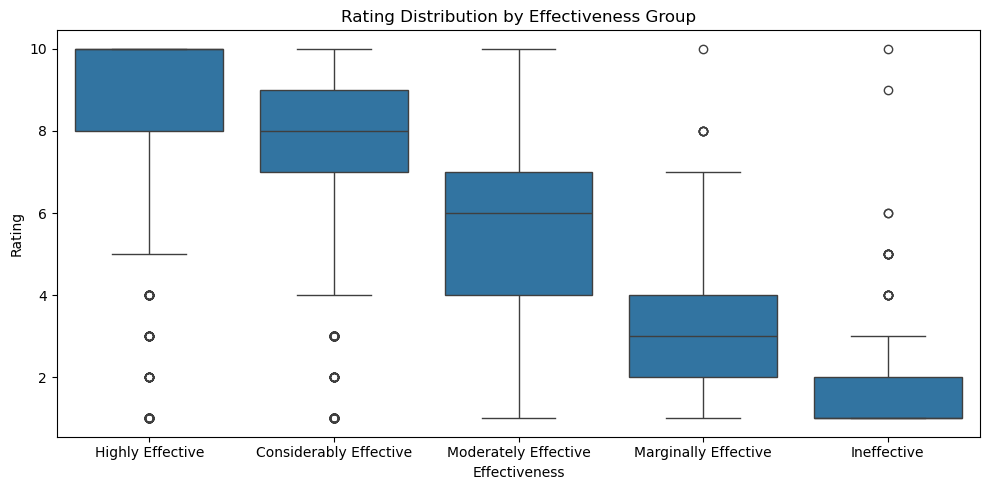

In [16]:
# Set an order for easier plot readability.
order = ["Highly Effective", "Considerably Effective", "Moderately Effective", "Marginally Effective", "Ineffective"]
cleaned_df["effectiveness"] = pd.Categorical(cleaned_df["effectiveness"], categories=order, ordered=True)

# Ratings vs Effectiveness
# This plot sings the same tune as the previous two, however, it shows that there are outliers, predominantly in the highly effective and ineffective groups.
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_df, x="effectiveness", y="rating")
plt.title("Rating Distribution by Effectiveness Group")
plt.xlabel("Effectiveness")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

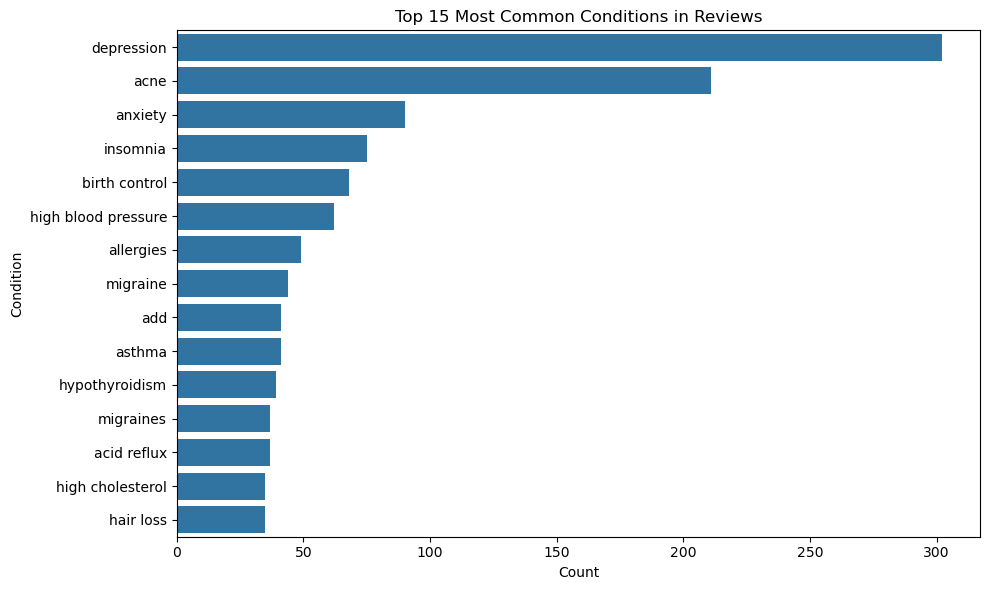

In [17]:
# 15 Most common conditions
# There isn't much to say here, however, the more common conditions may prove easier to predict given more data.
plt.figure(figsize=(10, 6))
top_conditions = cleaned_df["condition"].value_counts().nlargest(15)
sns.barplot(y=top_conditions.index, x=top_conditions.values)
plt.title("Top 15 Most Common Conditions in Reviews")
plt.xlabel("Count")
plt.ylabel("Condition")
plt.tight_layout()
plt.show()

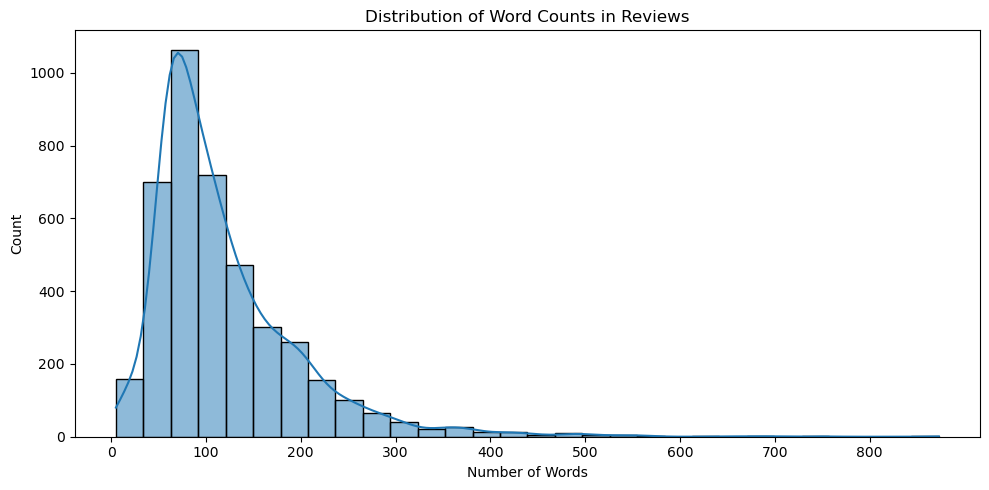

In [18]:
# Plot the distribution of word counts
# Most reviews have fewer than 200 words, the outliers seen toward 900 words
cleaned_df["review_length"] = cleaned_df["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(data=cleaned_df, x="review_length", bins=30, kde=True)
plt.title("Distribution of Word Counts in Reviews")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.xticks(ticks=range(0, 900, 100))
plt.tight_layout()
plt.show()

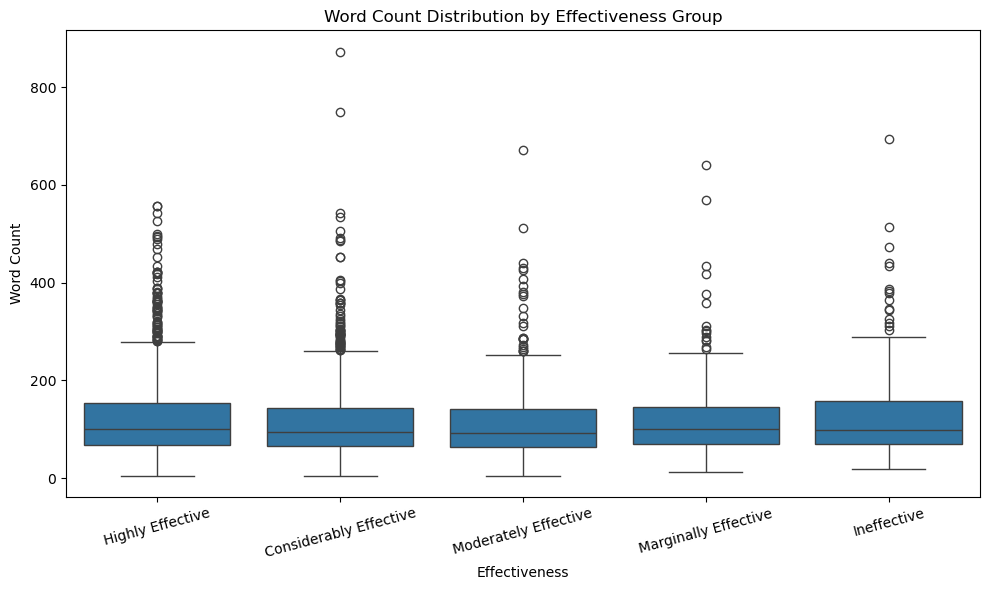

In [19]:
# Word count vs effectiveness
# This plot seems to indicate a higher average wordcount for lower effectiveness categories. This may suggest that reviews that are wordier are dissatisfied with their drug.
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x="effectiveness", y="review_length")
plt.title("Word Count Distribution by Effectiveness Group")
plt.xlabel("Effectiveness")
plt.ylabel("Word Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## KMeans Clustering/PCA

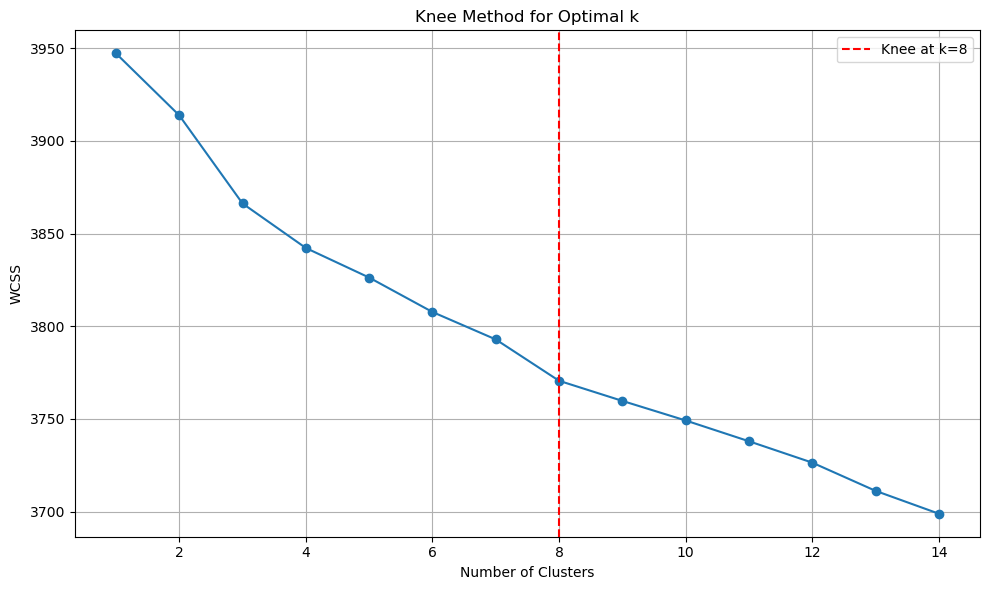

In [21]:
# Vectorize the review text 
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X_text = vectorizer.fit_transform(cleaned_df["review"])

# Apply KMeans clustering to find natural groupings in reviews
# Find optimal k value using elbow/knee method https://pypi.org/project/kneed/#find-knee

wcss = []
k_range = range(1,15)
for k in (k_range):
    kmeans = kmeans = KMeans(n_clusters=k, random_state=4252025)
    kmeans.fit(X_text)
    wcss.append(kmeans.inertia_)

# Use kneelocator to find the optimal k value
knee = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
optimal_k = knee.knee

# Plot with knee marked
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker="o")
plt.axvline(optimal_k, color="red", linestyle="--", label=f"Knee at k={optimal_k}")
plt.title("Knee Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

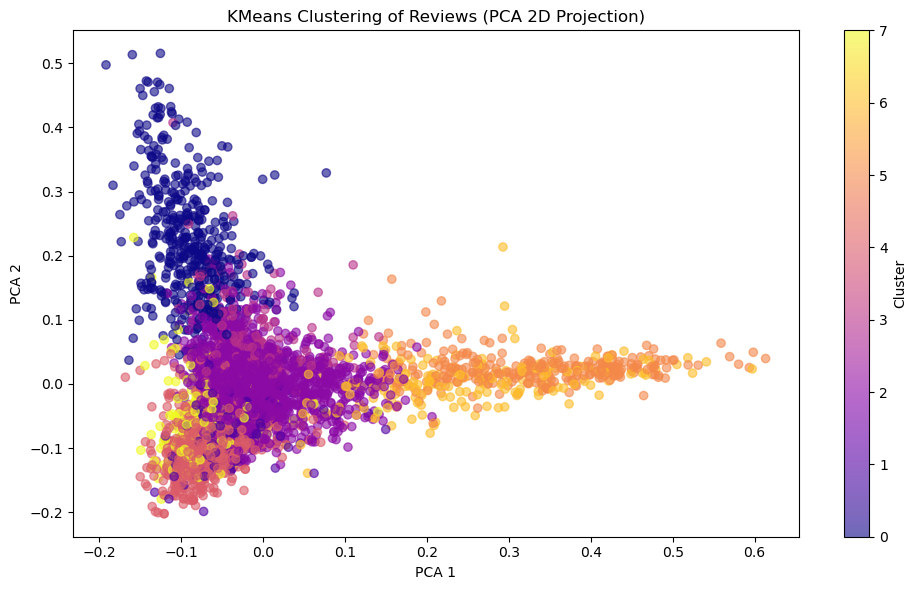

In [22]:
kmeans = KMeans(n_clusters=optimal_k, random_state=4252025)
clusters = kmeans.fit_predict(X_text)

# Add cluster assignments back to the dataframe
cleaned_df["cluster"] = clusters

# The TF-IDF vecorization results in one feature per word and its importance to the review. Since the result has too many dimensions for visualization, PCA is applied to reduce dimensionality for 2D viewing.
pca = PCA(n_components=2, random_state=4252025)
X_reduced = pca.fit_transform(X_text.toarray())

# Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap="plasma", alpha=0.6)
plt.title("KMeans Clustering of Reviews (PCA 2D Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()

The plot shows clusters represented by different colors, and the spread shows a naturally occruing groups of distinct clusters.
This could indicate a meaningful difference in the contents of the review text.

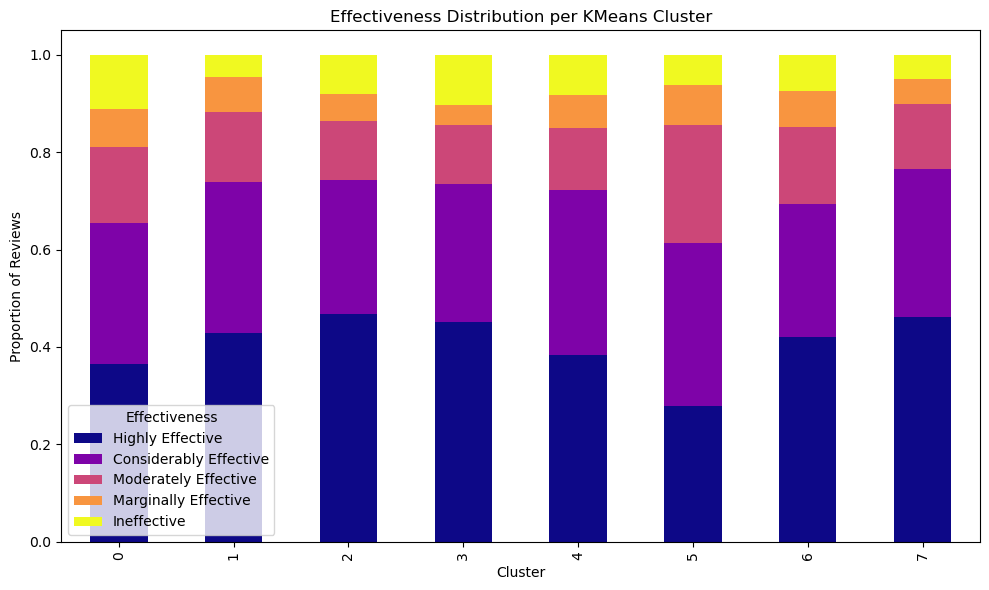

In [24]:
effectiveness_by_cluster = cleaned_df.groupby("cluster")["effectiveness"].value_counts(normalize=True).unstack().fillna(0)

effectiveness_by_cluster.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="plasma")
plt.title("Effectiveness Distribution per KMeans Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion of Reviews")
plt.legend(title="Effectiveness")
plt.tight_layout()
plt.show()

This plot shows the target lable (effectiveness) across each cluster. Some clusters have an elevated number of "Highly Effective" (2,3,7), while others are more balanced.

In [26]:
# Train/Test Split
X = cleaned_df.drop(columns=["effectiveness", "source"])  # Drop target and source
y = cleaned_df["effectiveness"]

# Stratifying is super important due to the perceived imbalance of effectiveness in our EDA.
# This should ensure our test and train data have a near equal balance of each effectiveness reviews as the other.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4252025, stratify=y)

# Save the splits to CSVs for modeling (Unlike our last project, scaling shouldn't be done yet, as our current features are mainly text based)
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train/Test split complete. Files saved:")

Train/Test split complete. Files saved:


# GRU Model (Gated Recurrent Units)
Some parts of the below code all takes a long time to run so it's been grayed out so it doesn't get run again.

In [28]:
def clean_review(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Load the training and testing sets
X_train = pd.read_csv("model_data/X_train.csv")
X_test = pd.read_csv("model_data/X_test.csv")
y_train = pd.read_csv("model_data/y_train.csv").squeeze()
y_test = pd.read_csv("model_data/y_test.csv").squeeze()

# remove excess noise from the review text
X_train["review"] = X_train["review"].apply(clean_review)
X_test["review"] = X_test["review"].apply(clean_review)

# Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# Give weights to balance the underrepresented classes
class_weights = dict(enumerate(compute_class_weight(class_weight="balanced", classes=np.unique(y_train_enc), y=y_train_enc)))

vocab_size = 5000
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train["review"])

X_train_seq = tokenizer.texts_to_sequences(X_train["review"])
X_test_seq = tokenizer.texts_to_sequences(X_test["review"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")

In [29]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Choice("embedding_dim", [16, 128]), input_length=hp.Choice("max_length", [50, 100, 150, 200])))
    model.add(Bidirectional(GRU(hp.Choice("gru_units", [32, 64, 128]), return_sequences=False)))
    model.add(Dropout(hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])))
    model.add(Dense(hp.Choice("dense_units", [32, 64, 128]), activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation="softmax"))  # or 2 for binary
    model.compile(optimizer=Adam(hp.Choice("lr", [.001, .0001, .0005, .00001, .00005])), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [30]:
'''
tuner = kt.Hyperband(build_model, objective="val_accuracy", max_epochs=10, directory="hyper_tune_results",
    project_name="gru_model_tuning")

early_stop = EarlyStopping(monitor="val_loss", patience=6)

tuner.search(X_train_pad, y_train_enc, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop],
    class_weight=class_weights)

Trial 30 Complete [00h 01m 13s]
val_accuracy: 0.3815988004207611

Best val_accuracy So Far: 0.4162895977497101
Total elapsed time: 00h 13m 22s


In [31]:
# Retrieve best model
best_model = tuner.get_best_models(num_models=1)[0]

In [32]:
# Evaluate it
loss, acc = best_model.evaluate(X_test_pad, y_test_enc)
print(f"\nBest Tuned Model Accuracy: {acc:.4f}")

best_hps = tuner.get_best_hyperparameters(1)[0]
print("\n Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3619 - loss: 1.6113

Best Tuned Model Accuracy: 0.4125

 Best Hyperparameters:
embedding_dim: 128
max_length: 50
gru_units: 128
dropout_rate: 0.5
dense_units: 64
lr: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [64]:
# Build the model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.get("embedding_dim")))
    model.add(Bidirectional(GRU(hp.get("gru_units"))))
    model.add(Dropout(hp.get("dropout_rate")))
    model.add(Dense(hp.get("dense_units"), activation="relu", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer=Adam(hp.get("lr")), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [66]:
# Run model
model = build_model(best_hps)
# set custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

C:\Users\ajcol\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [68]:
# Set up an earlystop to control overfitting and a checkpoint to store the best model
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_lstm_model.keras", monitor="val_accuracy", save_best_only=True)

In [70]:
'''
mynet = model.fit(X_train_pad, y_train_enc, validation_split=.2, epochs=50, batch_size=256, class_weight=class_weights,
    callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - accuracy: 0.1927 - loss: 1.7282 - val_accuracy: 0.2202 - val_loss: 1.7152
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - accuracy: 0.2072 - loss: 1.6853 - val_accuracy: 0.2911 - val_loss: 1.7136
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step - accuracy: 0.2319 - loss: 1.7118 - val_accuracy: 0.3002 - val_loss: 1.7120
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 547ms/step - accuracy: 0.2206 - loss: 1.7023 - val_accuracy: 0.3213 - val_loss: 1.7095
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - accuracy: 0.2464 - loss: 1.7114 - val_accuracy: 0.3122 - val_loss: 1.7080
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - accuracy: 0.2462 - loss: 1.7039 - val_accuracy: 0.3213 - val_loss: 1.7059
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 563ms/step - accuracy: 0.2510 - loss: 1.6766 - val_accuracy: 0.3288 - val_loss: 1.7036
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.2531 - loss: 1.7009 - val_accuracy: 0.

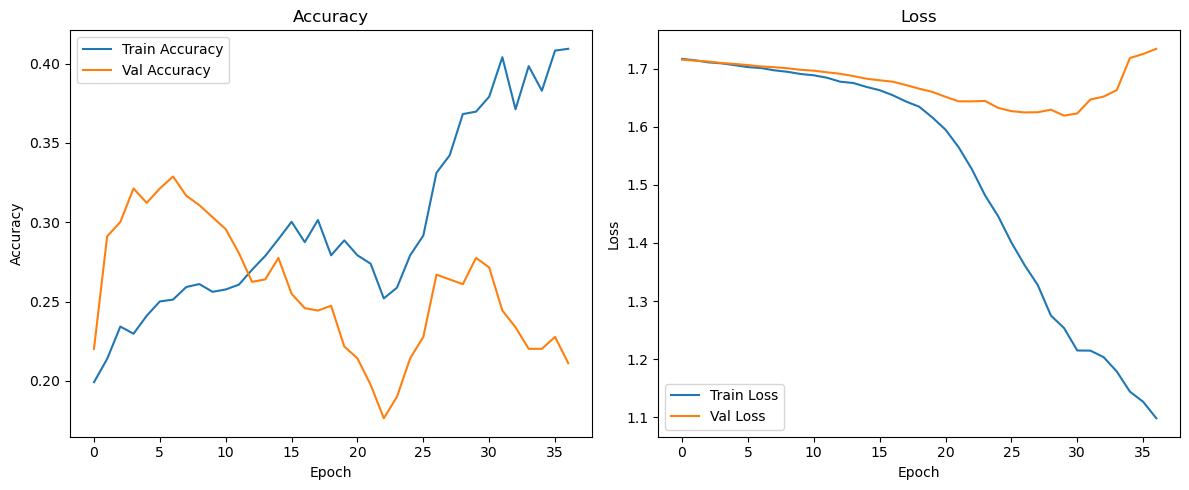

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3015 - loss: 1.5798

Final Test Accuracy: 0.3209


In [72]:
# Plot the training/validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mynet.history["accuracy"], label="Train Accuracy")
plt.plot(mynet.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mynet.history["loss"], label="Train Loss")
plt.plot(mynet.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

loss, acc = model.evaluate(X_test_pad, y_test_enc)
print(f"\nFinal Test Accuracy: {acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


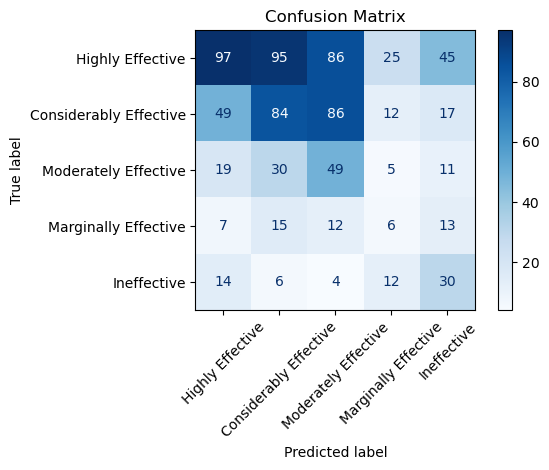

In [76]:
# Predict
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

# Confusion Matrix 
labels_order = ["Highly Effective", "Considerably Effective", "Moderately Effective", "Marginally Effective", "Ineffective"]
encoded_label_order = [encoder.transform([label])[0] for label in labels_order]

cm = confusion_matrix(y_test_enc, y_pred, labels=encoded_label_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [78]:
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))


Classification Report:
                        precision    recall  f1-score   support

Considerably Effective       0.37      0.34      0.35       248
      Highly Effective       0.52      0.28      0.36       348
           Ineffective       0.26      0.45      0.33        66
  Marginally Effective       0.10      0.11      0.11        53
  Moderately Effective       0.21      0.43      0.28       114

              accuracy                           0.32       829
             macro avg       0.29      0.32      0.29       829
          weighted avg       0.38      0.32      0.33       829



The plots generated make it clear that training as I did, using TF-IDF vectorization and a GRU recurrent neural net, stalls out around 40% accuracy.
This could be a limit of the model's perception of the text, or that there are too many of the "Highly Effective" class. 
This class specifically makes up nearly 43 percent of the dataset and as such, 40% accuracy could be gained by guessing Highly Effective each time.

# Logistic Regression with Clusters

In [29]:
X_train = pd.read_csv("model_data/X_train.csv")
X_test = pd.read_csv("model_data/X_test.csv")
y_train = pd.read_csv("model_data/y_train.csv").squeeze()
y_test = pd.read_csv("model_data/y_test.csv").squeeze()

classes = np.unique(y_train)

# Compute class weights and create dictionary with actual class labels
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights)) 

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X_train_text = vectorizer.fit_transform(X_train["review"])
X_test_text = vectorizer.transform(X_test["review"])

# Initialize Logistic Regression for multi-class
logreg = LogisticRegression(class_weight=class_weights, solver="lbfgs", max_iter=1000, random_state=4252025)

# Fit model
logreg.fit(X_train_text, y_train)

# Predict on test set
y_pred = logreg.predict(X_test_text)

In [31]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

                        precision    recall  f1-score   support

Considerably Effective       0.37      0.31      0.34       248
      Highly Effective       0.57      0.42      0.48       348
           Ineffective       0.20      0.29      0.23        66
  Marginally Effective       0.16      0.34      0.22        53
  Moderately Effective       0.22      0.30      0.26       114

              accuracy                           0.36       829
             macro avg       0.30      0.33      0.31       829
          weighted avg       0.41      0.36      0.37       829



In [33]:
# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[ 78  69  18  31  52]
 [ 94 146  31  30  47]
 [  7  11  19  19  10]
 [  8   6  12  18   9]
 [ 26  24  16  14  34]]


These results are quite poor, even worse than random guessing, but not by much. Let's tweak the ngram range and max features to  see if we can get better predictions.

In [36]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000, ngram_range=(1,5))
X_train_text = vectorizer.fit_transform(X_train["review"])
X_test_text = vectorizer.transform(X_test["review"])

# Initialize Logistic Regression for multi-class
logreg = LogisticRegression(class_weight=class_weights, solver="lbfgs", max_iter=1000, random_state=4252025)

In [37]:
# Fit model
logreg.fit(X_train_text, y_train)

LogisticRegression(class_weight={'Considerably Effective': 0.6694949494949495,
                                 'Highly Effective': 0.4758076094759512,
                                 'Ineffective': 2.520152091254753,
                                 'Marginally Effective': 3.156190476190476,
                                 'Moderately Effective': 1.4471615720524018},
                   max_iter=1000, random_state=4252025)

In [42]:
# Predict on test set
y_pred = logreg.predict(X_test_text)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

                        precision    recall  f1-score   support

Considerably Effective       0.37      0.31      0.34       248
      Highly Effective       0.58      0.51      0.55       348
           Ineffective       0.24      0.32      0.28        66
  Marginally Effective       0.14      0.23      0.18        53
  Moderately Effective       0.22      0.29      0.25       114

              accuracy                           0.39       829
             macro avg       0.31      0.33      0.32       829
          weighted avg       0.42      0.39      0.40       829



In [44]:
# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[ 77  81  16  27  47]
 [ 82 179  25  19  43]
 [  7  10  21  15  13]
 [  8  10  11  12  12]
 [ 32  26  13  10  33]]


These results show an improvement the balance across the classes, while the overall accuracy barely increased. This is an acceptable change, as the dataset is imbalanced and improving the predictability of the minority classes is necessary. However, it seems that logistic regression isn't quite the model we need to predict effectiveness based on text reviews.

# Logistic Regression with No Clusters

In [48]:
X_train = pd.read_csv("model_data/X_train.csv")
X_test = pd.read_csv("model_data/X_test.csv")
y_train = pd.read_csv("model_data/y_train.csv").squeeze()
y_test = pd.read_csv("model_data/y_test.csv").squeeze()


if 'cluster' in X_train.columns:
    X_train = X_train.drop(columns=["cluster"])
    X_test = X_test.drop(columns=["cluster"])


tfidf = TfidfVectorizer(stop_words="english", max_features=3000, ngram_range=(1, 2))

X_train_text = tfidf.fit_transform(X_train["review"])
X_test_text = tfidf.transform(X_test["review"])


logreg_nocluster = LogisticRegression(class_weight="balanced",solver="lbfgs", random_state=4252025, max_iter=500)
logreg_nocluster.fit(X_train_text, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=4252025)

In [52]:
y_pred_nocluster = logreg_nocluster.predict(X_test_text)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nocluster))


Classification Report:
                        precision    recall  f1-score   support

Considerably Effective       0.37      0.32      0.34       248
      Highly Effective       0.59      0.51      0.55       348
           Ineffective       0.24      0.30      0.26        66
  Marginally Effective       0.14      0.23      0.18        53
  Moderately Effective       0.22      0.28      0.25       114

              accuracy                           0.39       829
             macro avg       0.31      0.33      0.32       829
          weighted avg       0.42      0.39      0.40       829



In [54]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nocluster))


Confusion Matrix:
[[ 79  80  16  27  46]
 [ 85 179  26  18  40]
 [  7  10  20  16  13]
 [  8   9  11  12  13]
 [ 32  27  12  11  32]]


These results are nearly identical to the results with the cluster assignments, indicating no reason to include the clustering information for the logistic regression model.

# Conclusion 

Recurrent Neural Network (RNN) are the standard for sentiment analaysis, so it's clear that we chose the right neural network for this project. However, we were unable to identify any meaningful trends with the data, so there is likely some flaw with the dataset. Since the dataset consists of many different medications which treat various conditions, maybe there's too much variety to find any strong trends. Perhaps the nature of online reviews for medications is also flawed, since people who take medication represents every possible demographic, which has a wider audience than a commercial product that might be marketed to a specific age and gender. The biggest issues were likely the terrible overrepresentation of one of the five classes we were predicting combined with a very subjective text field as our training data. Overall, this model could still be effective if used on a more specific, target dataset.